# Setup

Dependencies:
- System: python3
- Python: jupyter, numpy, matplotlib, scipy, ipywidgets, opencv


In [1]:
# Load packages
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import cv2
import os

## First, let's load the data. We will images and point clouds from the KITTI dataset. 

In [2]:
# Load data
# Functions taken from https://github.com/charlesq34/frustum-pointnets/blob/master/kitti/kitti_object.py

def load_image(img_filename):
    return cv2.imread(img_filename)

def load_velo_scan(velo_filename, dtype=np.float32, n_vec=4):
    scan = np.fromfile(velo_filename, dtype=dtype)
    scan = scan.reshape((-1, n_vec))
    return scan

def inverse_rigid_trans(Tr):
    """ Inverse a rigid body transform matrix (3x4 as [R|t])
        [R'|-R't; 0|1]
    """
    inv_Tr = np.zeros_like(Tr)  # 3x4
    inv_Tr[0:3, 0:3] = np.transpose(Tr[0:3, 0:3])
    inv_Tr[0:3, 3] = np.dot(-np.transpose(Tr[0:3, 0:3]), Tr[0:3, 3])
    return inv_Tr

class Calibration(object):
    """ Calibration matrices and utils
        3d XYZ in <label>.txt are in rect camera coord.
        2d box xy are in image2 coord
        Points in <lidar>.bin are in Velodyne coord.

        y_image2 = P^2_rect * x_rect
        y_image2 = P^2_rect * R0_rect * Tr_velo_to_cam * x_velo
        x_ref = Tr_velo_to_cam * x_velo
        x_rect = R0_rect * x_ref

        P^2_rect = [f^2_u,  0,      c^2_u,  -f^2_u b^2_x;
                    0,      f^2_v,  c^2_v,  -f^2_v b^2_y;
                    0,      0,      1,      0]
                 = K * [1|t]

        image2 coord:
         ----> x-axis (u)
        |
        |
        v y-axis (v)

        velodyne coord:
        front x, left y, up z

        rect/ref camera coord:
        right x, down y, front z

        Ref (KITTI paper): http://www.cvlibs.net/publications/Geiger2013IJRR.pdf
    """

    def __init__(self, calib_filepath, from_video=False):
        if from_video:
            calibs = self.read_calib_from_video(calib_filepath)
        else:
            calibs = self.read_calib_file(calib_filepath)
        # Projection matrix from rect camera coord to image2 coord
        self.P = calibs["P2"]
        self.P = np.reshape(self.P, [3, 4])
        # Rigid transform from Velodyne coord to reference camera coord
        self.V2C = calibs["Tr_velo_to_cam"]
        self.V2C = np.reshape(self.V2C, [3, 4])
        self.C2V = inverse_rigid_trans(self.V2C)
        # Rotation from reference camera coord to rect camera coord
        self.R0 = calibs["R0_rect"]
        self.R0 = np.reshape(self.R0, [3, 3])

        # Camera intrinsics and extrinsics
        self.c_u = self.P[0, 2]
        self.c_v = self.P[1, 2]
        self.f_u = self.P[0, 0]
        self.f_v = self.P[1, 1]
        self.b_x = self.P[0, 3] / (-self.f_u)  # relative
        self.b_y = self.P[1, 3] / (-self.f_v)

    def read_calib_file(self, filepath):
        """ Read in a calibration file and parse into a dictionary.
        Ref: https://github.com/utiasSTARS/pykitti/blob/master/pykitti/utils.py
        """
        data = {}
        with open(filepath, "r") as f:
            for line in f.readlines():
                line = line.rstrip()
                if len(line) == 0:
                    continue
                key, value = line.split(":", 1)
                # The only non-float values in these files are dates, which
                # we don't care about anyway
                try:
                    data[key] = np.array([float(x) for x in value.split()])
                except ValueError:
                    pass

        return data

    def read_calib_from_video(self, calib_root_dir):
        """ Read calibration for camera 2 from video calib files.
            there are calib_cam_to_cam and calib_velo_to_cam under the calib_root_dir
        """
        data = {}
        cam2cam = self.read_calib_file(
            os.path.join(calib_root_dir, "calib_cam_to_cam.txt")
        )
        velo2cam = self.read_calib_file(
            os.path.join(calib_root_dir, "calib_velo_to_cam.txt")
        )
        Tr_velo_to_cam = np.zeros((3, 4))
        Tr_velo_to_cam[0:3, 0:3] = np.reshape(velo2cam["R"], [3, 3])
        Tr_velo_to_cam[:, 3] = velo2cam["T"]
        data["Tr_velo_to_cam"] = np.reshape(Tr_velo_to_cam, [12])
        data["R0_rect"] = cam2cam["R_rect_00"]
        data["P2"] = cam2cam["P_rect_02"]
        return data

    def cart2hom(self, pts_3d):
        """ Input: nx3 points in Cartesian
            Oupput: nx4 points in Homogeneous by pending 1
        """
        n = pts_3d.shape[0]
        pts_3d_hom = np.hstack((pts_3d, np.ones((n, 1))))
        return pts_3d_hom

    # ===========================
    # ------- 3d to 3d ----------
    # ===========================
    def project_velo_to_ref(self, pts_3d_velo):
        pts_3d_velo = self.cart2hom(pts_3d_velo)  # nx4
        return np.dot(pts_3d_velo, np.transpose(self.V2C))

    def project_ref_to_rect(self, pts_3d_ref):
        """ Input and Output are nx3 points """
        return np.transpose(np.dot(self.R0, np.transpose(pts_3d_ref)))

    def project_velo_to_rect(self, pts_3d_velo):
        pts_3d_ref = self.project_velo_to_ref(pts_3d_velo)
        return self.project_ref_to_rect(pts_3d_ref)

    # ===========================
    # ------- 3d to 2d ----------
    # ===========================
    def project_rect_to_image(self, pts_3d_rect):
        """ Input: nx3 points in rect camera coord.
            Output: nx2 points in image2 coord.
        """
        pts_3d_rect = self.cart2hom(pts_3d_rect)
        pts_2d = np.dot(pts_3d_rect, np.transpose(self.P))  # nx3
        pts_2d[:, 0] /= pts_2d[:, 2]
        pts_2d[:, 1] /= pts_2d[:, 2]
        return pts_2d[:, 0:2]

    def project_velo_to_image(self, pts_3d_velo):
        """ Input: nx3 points in velodyne coord.
            Output: nx2 points in image2 coord.
        """
        pts_3d_rect = self.project_velo_to_rect(pts_3d_velo)
        return self.project_rect_to_image(pts_3d_rect)


In [3]:
class kitti_object(object):
    """Load and parse object data into a usable format."""

    def __init__(self, root_dir, split="training", args=None):
        """root_dir contains training and testing folders"""
        self.root_dir = root_dir
        self.split = split
        self.split_dir = os.path.join(root_dir, split)

        if split == "training":
            self.num_samples = 7481
        elif split == "testing":
            self.num_samples = 7518
        else:
            print("Unknown split: %s" % (split))
            exit(-1)

        lidar_dir = "velodyne"
        depth_dir = "depth"
        pred_dir = "pred"
        if args is not None:
            lidar_dir = args.lidar
            depth_dir = args.depthdir
            pred_dir = args.preddir

        self.image_dir = os.path.join(self.split_dir, "image_2")
        self.label_dir = os.path.join(self.split_dir, "label_2")
        self.calib_dir = os.path.join(self.split_dir, "calib")

        self.depthpc_dir = os.path.join(self.split_dir, "depth_pc")
        self.lidar_dir = os.path.join(self.split_dir, lidar_dir)
        self.depth_dir = os.path.join(self.split_dir, depth_dir)
        self.pred_dir = os.path.join(self.split_dir, pred_dir)

    def __len__(self):
        return self.num_samples

    def get_image(self, idx):
        assert idx < self.num_samples
        img_filename = os.path.join(self.image_dir, "%06d.png" % (idx))
        return load_image(img_filename)

    def get_lidar(self, idx, dtype=np.float32, n_vec=4):
        assert idx < self.num_samples
        lidar_filename = os.path.join(self.lidar_dir, "%06d.bin" % (idx))
        return load_velo_scan(lidar_filename, dtype, n_vec)

    def get_calibration(self, idx):
        assert idx < self.num_samples
        calib_filename = os.path.join(self.calib_dir, "%06d.txt" % (idx))
        return Calibration(calib_filename)

In [4]:
dataset = kitti_object('./data/object', 'training')
data_idx = 0
pc_velo = dataset.get_lidar(data_idx)
calib = dataset.get_calibration(data_idx)
img = dataset.get_image(data_idx)
img_height, img_width, _ = img.shape

## Let's take a look at the RGB image.

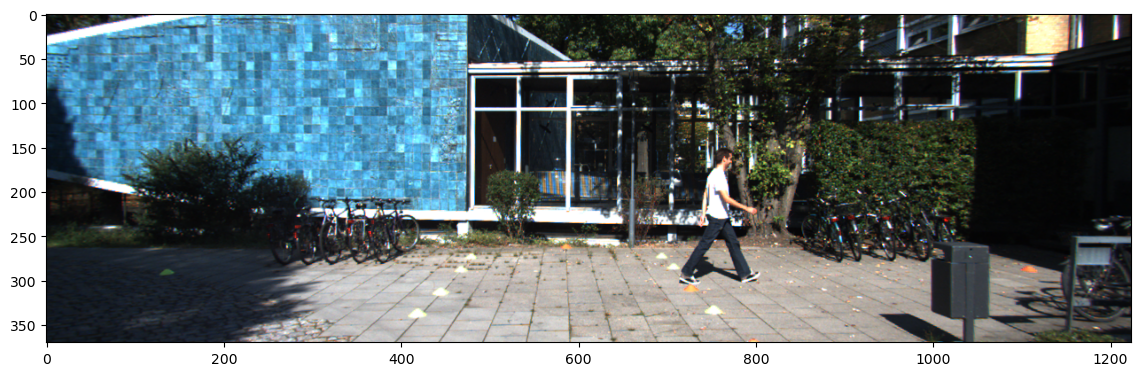

In [5]:
# Show RGB image
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
fig_rgb = plt.figure(figsize=(14, 7))
ax_rgb = fig_rgb.subplots()
ax_rgb.imshow(img)
plt.show()

## Now let's plot the 3D point cloud data, as well as the projection of the 3D data onto various planes.

In [6]:
axes_limits = [
    [-60, 60], # X axis range
    [-20, 40], # Y axis range
    [-4, 4]   # Z axis range
]
axes_str = ['X', 'Y', 'Z']

def draw_box(pyplot_axis, vertices, axes=[0, 1, 2], color='black'):
    """
    Draws a bounding 3D box in a pyplot axis.
    
    Parameters
    ----------
    pyplot_axis : Pyplot axis to draw in.
    vertices    : Array 8 box vertices containing x, y, z coordinates.
    axes        : Axes to use. Defaults to `[0, 1, 2]`, e.g. x, y and z axes.
    color       : Drawing color. Defaults to `black`.
    """
    vertices = vertices[axes, :]
    connections = [
        [0, 1], [1, 2], [2, 3], [3, 0],  # Lower plane parallel to Z=0 plane
        [4, 5], [5, 6], [6, 7], [7, 4],  # Upper plane parallel to Z=0 plane
        [0, 4], [1, 5], [2, 6], [3, 7]   # Connections between upper and lower planes
    ]
    for connection in connections:
        pyplot_axis.plot(*vertices[:, connection], c=color, lw=0.5)

def display_frame(pc_velo, points=1, point_colors=None):
    """
    Draws 3D plot of the lidar point cloud data and point cloud projections to various planes.
    
    Parameters
    ----------
    pc_velo     : 3D point cloud data. 
    points      : Fraction of lidar points to use. 
    colors      : List of colors for each point. 
    """
    points_step = int(1. / points)
    point_size = 0.01 * (1. / points)
    velo_range = range(0, pc_velo.shape[0], points_step)
    velo_frame = pc_velo[velo_range, :]      
    def draw_point_cloud(ax, title, axes=[0, 1, 2], xlim3d=None, ylim3d=None, zlim3d=None, point_colors=None):
        """
        Convenient method for drawing various point cloud projections.
        """
        if point_colors == None:
            ax.scatter(*np.transpose(velo_frame[:, axes]), s=point_size, c=velo_frame[:, 3], cmap='gray')
        else:
            ax.scatter(*np.transpose(velo_frame[:, axes]), s=point_size, c=point_colors)
        ax.set_title(title)
        ax.set_xlabel('{} axis'.format(axes_str[axes[0]]))
        ax.set_ylabel('{} axis'.format(axes_str[axes[1]]))
        if len(axes) > 2:
            ax.set_xlim3d(*axes_limits[axes[0]])
            ax.set_ylim3d(*axes_limits[axes[1]])
            ax.set_zlim3d(*axes_limits[axes[2]])
            ax.set_zlabel('{} axis'.format(axes_str[axes[2]]))
        else:
            ax.set_xlim(*axes_limits[axes[0]])
            ax.set_ylim(*axes_limits[axes[1]])
        # User specified limits
        if xlim3d!=None:
            ax.set_xlim3d(xlim3d)
        if ylim3d!=None:
            ax.set_ylim3d(ylim3d)
        if zlim3d!=None:
            ax.set_zlim3d(zlim3d)
                        
    # Draw point cloud data as 3D plot
    f2 = plt.figure(figsize=(15, 8))
    ax2 = f2.add_subplot(111, projection='3d')                    
    draw_point_cloud(ax2, 'Velodyne scan', xlim3d=(-10,30), point_colors=point_colors)
    plt.show()
    
    # Draw point cloud data as plane projections
    f, ax3 = plt.subplots(3, 1, figsize=(15, 25))
    draw_point_cloud(
        ax3[0], 
        'Velodyne scan, XZ projection (Y = 0)', 
        axes=[0, 2], # X and Z axes
        point_colors=point_colors
    )
    draw_point_cloud(
        ax3[1], 
        'Velodyne scan, XY projection (Z = 0)', 
        axes=[0, 1], # X and Y axes
        point_colors=point_colors
    )
    draw_point_cloud(
        ax3[2], 
        'Velodyne scan, YZ projection (X = 0)', 
        axes=[1, 2], # Y and Z axes
        point_colors=point_colors
    )
    plt.show()

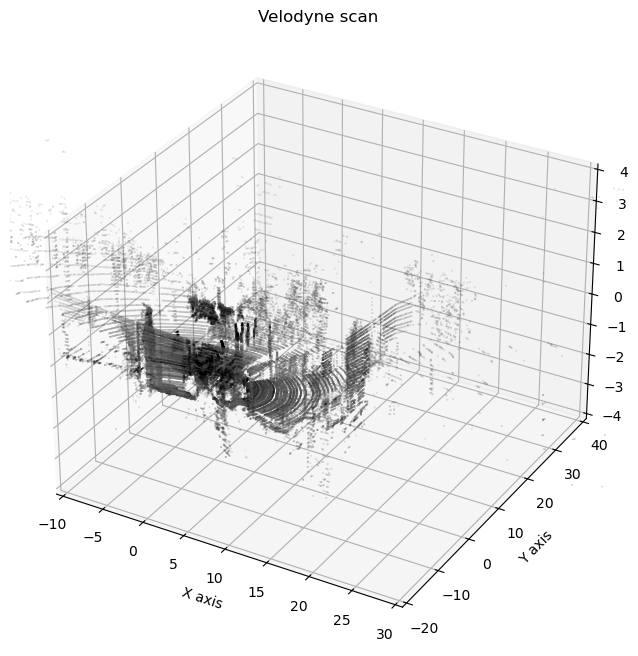

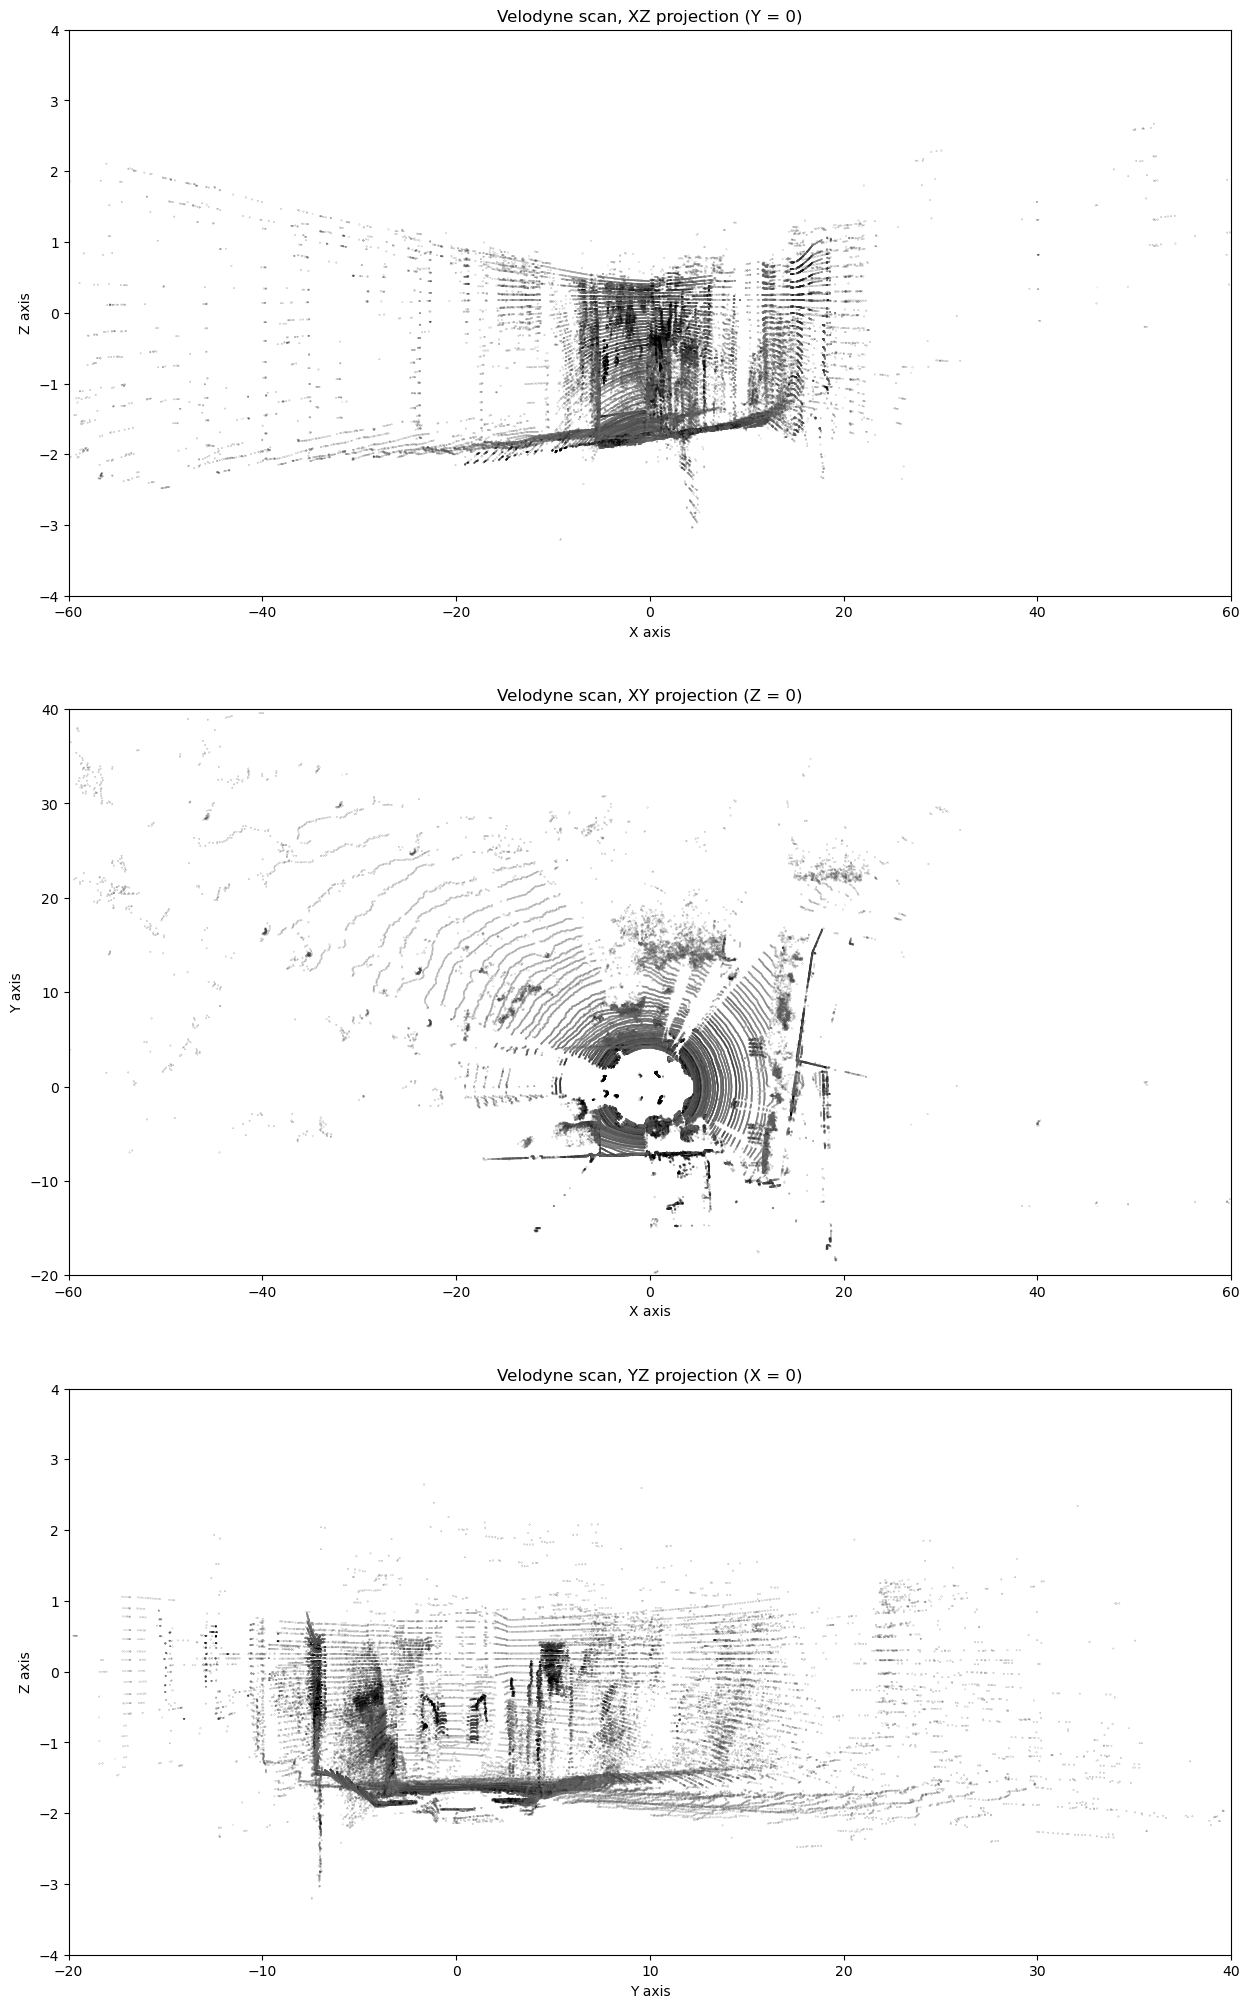

In [7]:
# Plot the point cloud data
display_frame(pc_velo)

## Now we'll align the point cloud data with the RGB image data. 

In [8]:
def get_lidar_in_image_fov(
    pc_velo, calib, xmin, ymin, xmax, ymax, return_more=False, clip_distance=2.0
):
    """ Filter lidar points, keep those in image FOV """
    pts_2d = calib.project_velo_to_image(pc_velo)
    fov_inds = (
        (pts_2d[:, 0] < xmax)
        & (pts_2d[:, 0] >= xmin)
        & (pts_2d[:, 1] < ymax)
        & (pts_2d[:, 1] >= ymin)
    )
    fov_inds = fov_inds & (pc_velo[:, 0] > clip_distance)
    imgfov_pc_velo = pc_velo[fov_inds, :]
    if return_more:
        return imgfov_pc_velo, pts_2d, fov_inds
    else:
        return imgfov_pc_velo

In [9]:
# Project the 3D point cloud data into 2D and check which points are in the image FOV
# imgfov_pc_velo [n_subset, 3]: the subset of 3D points that are in the image FOV
# pts_2d [n, 3]: all of the 3D points projected into 2D
# fov_inds [n]: each element of fov_inds is true if the corresponding 3D point is in the image FOV, and false otherwise 
# imgfov_pts_2d [n_subset, 2]: the subset of 3D points that are in the image FOV, projected into 2D

imgfov_pc_velo, pts_2d, fov_inds = get_lidar_in_image_fov(pc_velo[:, 0:3], calib, 0, 0, img_width, img_height, True)
imgfov_pts_2d = pts_2d[fov_inds, :]

In [10]:
print('Total number of 3d points: ', len(pc_velo))
print('Number of 3d points in the image FOV: ', len(imgfov_pts_2d))

Total number of 3d points:  115384
Number of 3d points in the image FOV:  20285


In [11]:
# For the 3D points that are in the image FOV, get the corresponding image colors. 
# If the point is not in the image FOV, set the color to black.

import math

def rgb2hex(r,g,b):
    return "#{:02x}{:02x}{:02x}".format(r,g,b)
    
point_colors = ['#000000']*len(pc_velo)
for i in range(len(pc_velo)):
    if fov_inds[i] == True:
        x_coord = math.floor(pts_2d[i][0])
        y_coord = math.floor(pts_2d[i][1])
        rgb_color = img[y_coord, x_coord, :]
        color = rgb2hex(rgb_color[0], rgb_color[1], rgb_color[2])
        point_colors[i] = color        

## Plot the 3D point cloud, coloring points with their corresponding RGB values 

Note that because most of the 3D points are outside of the image FOV, most of the points are black (there are 115384 3D point cloud points, and only 20285 are in the image FOV). However, we can distinctly see some elements of the RGB image here (e.g. the blue wall). 

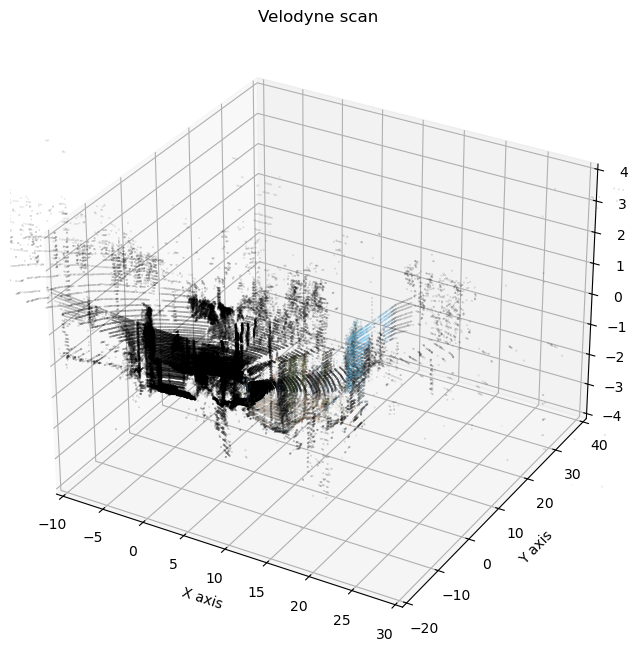

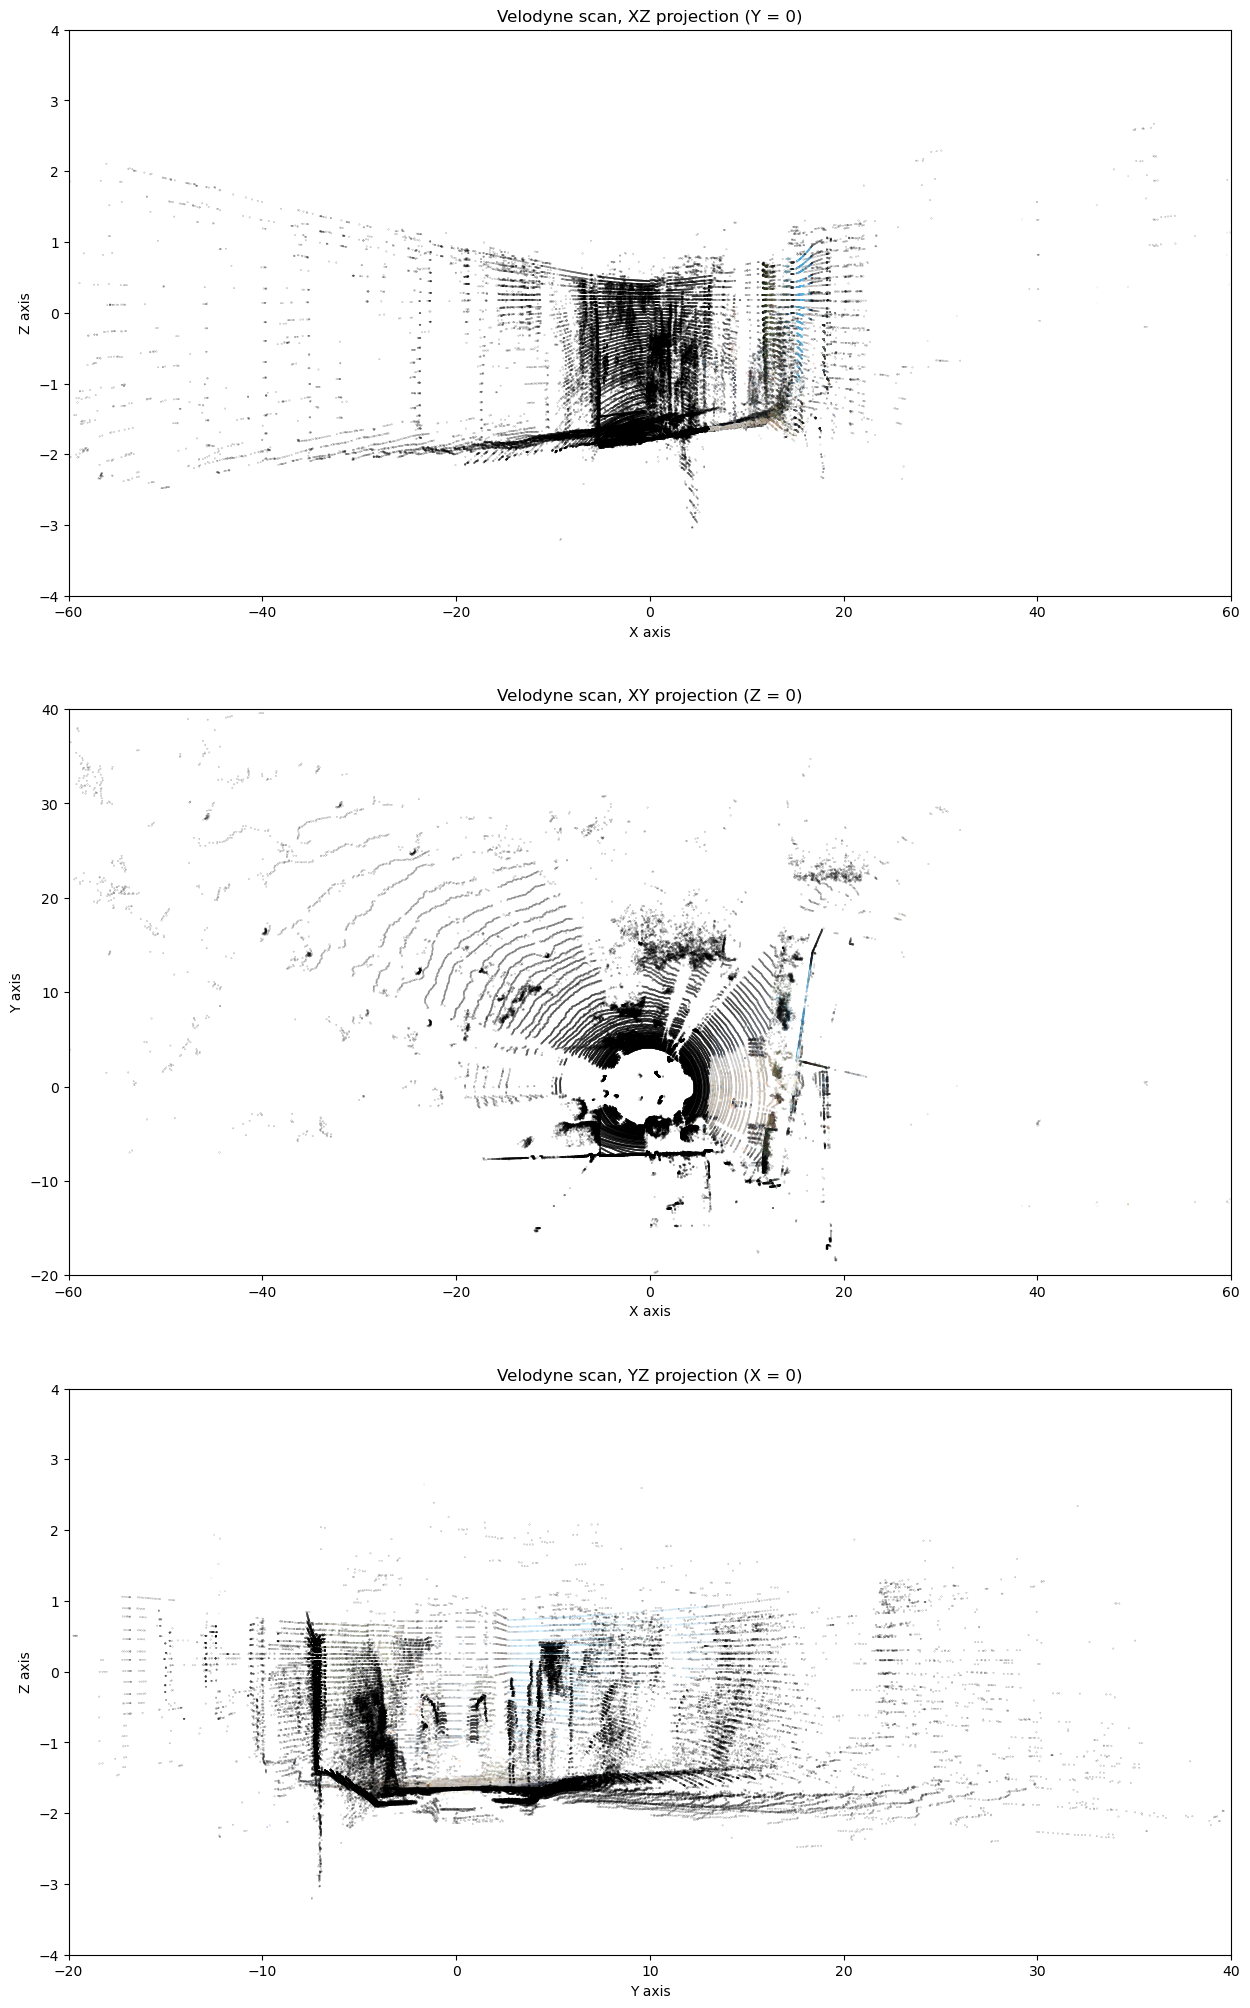

In [12]:
display_frame(pc_velo, point_colors=point_colors)

We can also plot just the subset of 3D points in the image FOV:

In [13]:
point_colors_subset = ['#000000']*len(imgfov_pc_velo)
for i in range(len(imgfov_pc_velo)):
    x_coord = math.floor(imgfov_pts_2d[i][0])
    y_coord = math.floor(imgfov_pts_2d[i][1])
    rgb_color = img[y_coord, x_coord, :]
    color = rgb2hex(rgb_color[0], rgb_color[1], rgb_color[2])
    point_colors_subset[i] = color

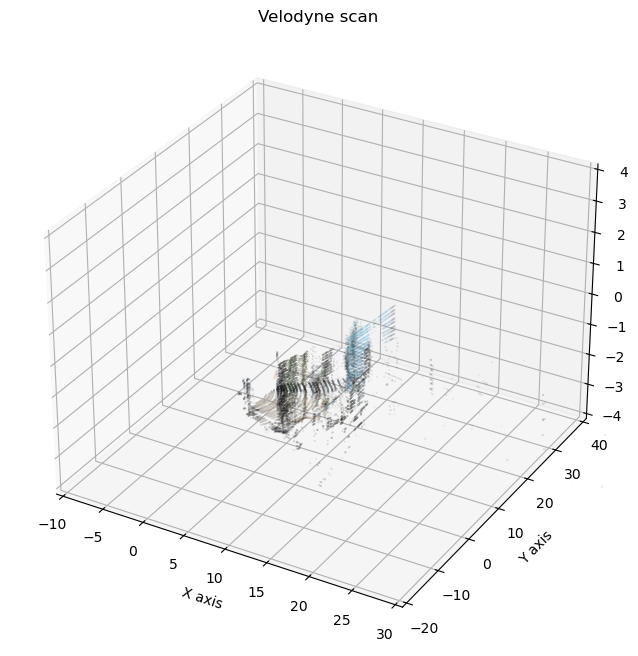

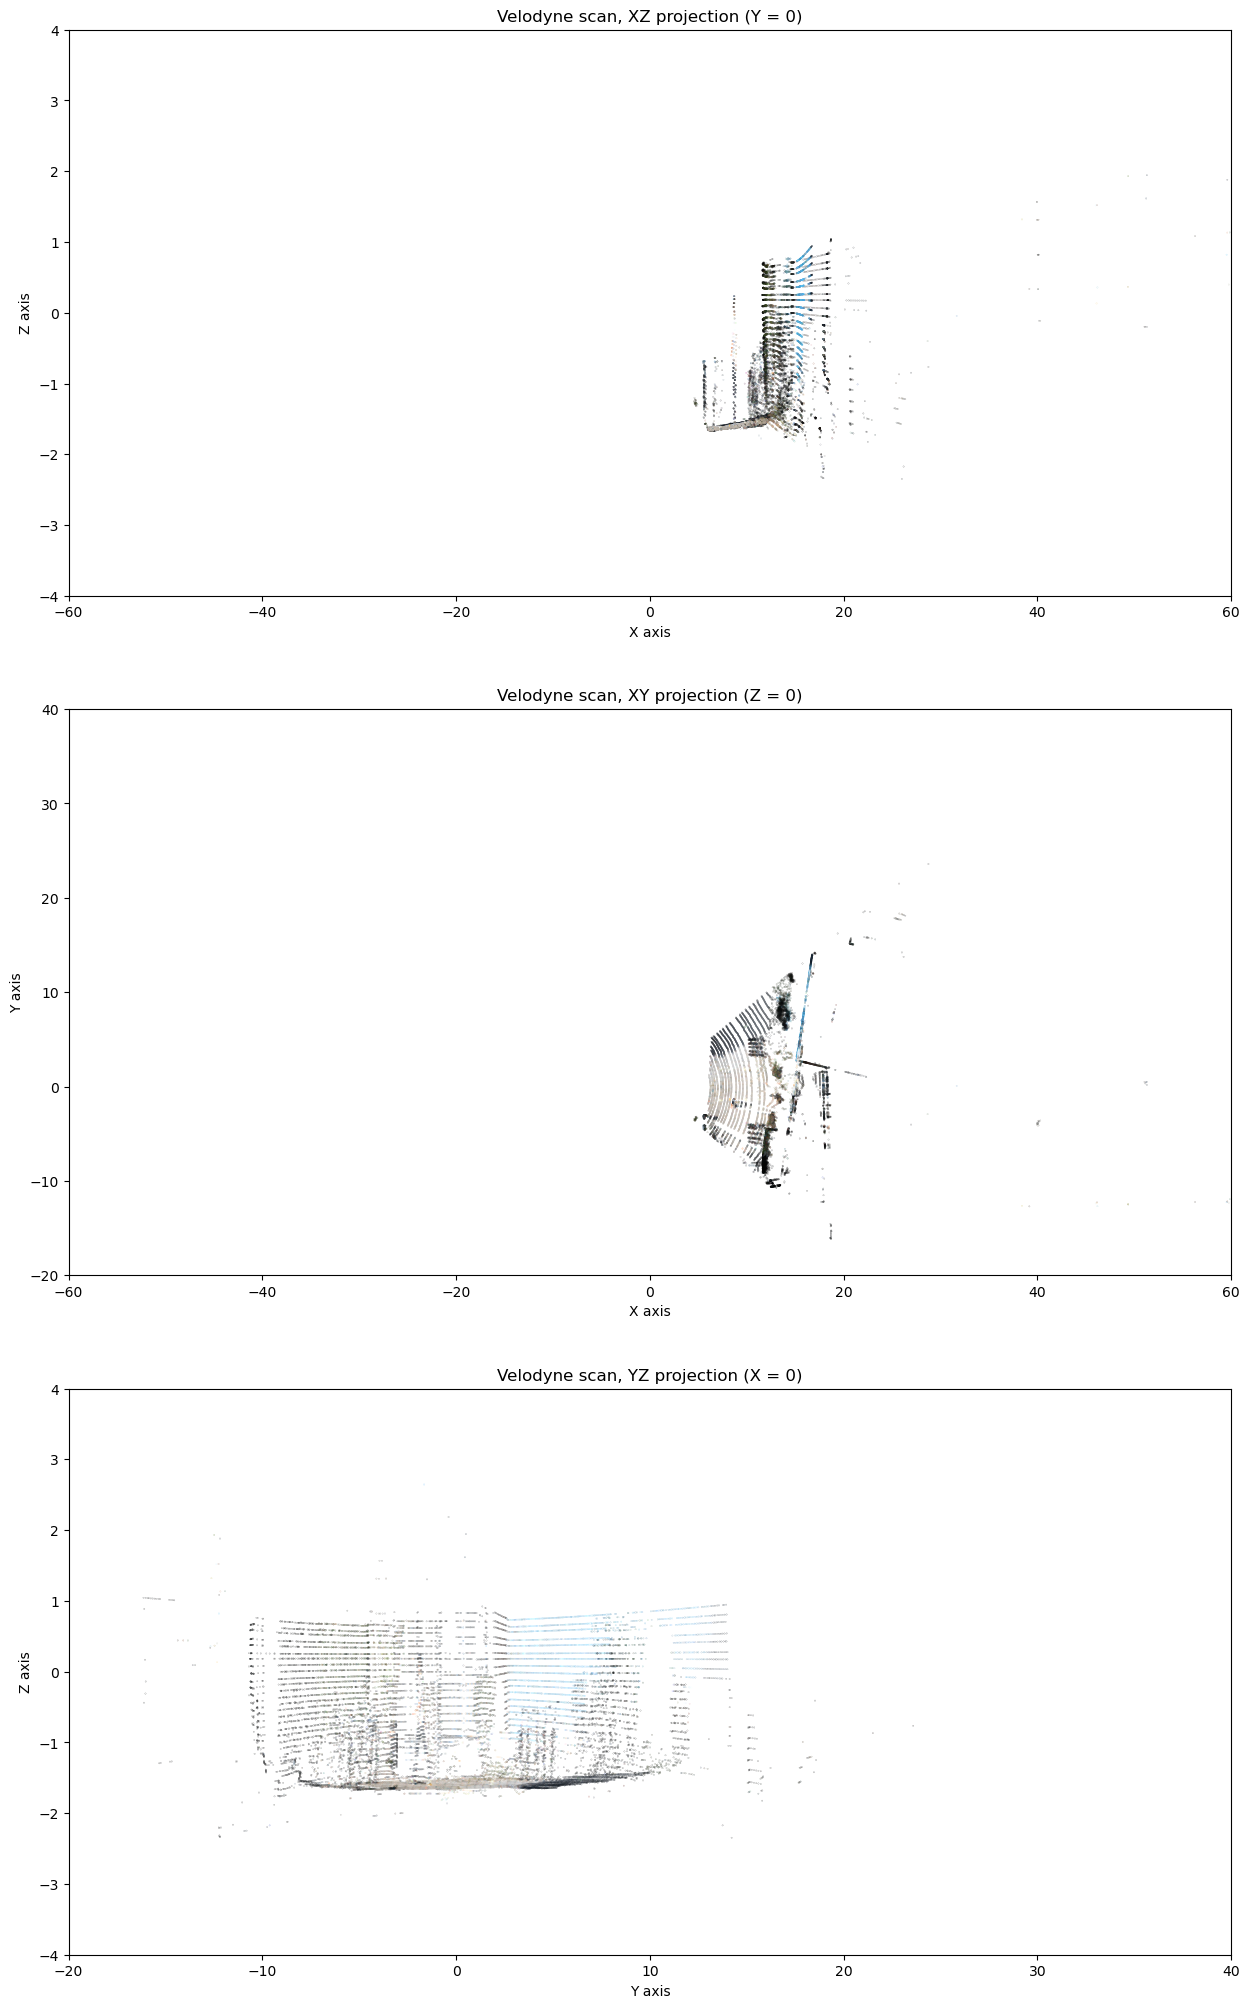

In [14]:
display_frame(imgfov_pc_velo, point_colors=point_colors_subset)